# About this notebook
This notebook tries different regression techniques in order to predict the battery voltage of a solar panel powered battery pack based on weather variables and/or previous battery voltages.

First the necessary libraries are imported. Next the data is loaded from local files that have been generated using the "Data collection and merging"-notebook. Next useful functions are defined that will be used to extend the dataframe, scale and split the data and plot it. In the second part, the different techniques follow that have been tried. These are:
 * Linear regression without regularization
     * no extra data
     * extra battery voltage data
     * extra weather variables
     * extra battery voltage data and extra weather variables
 * Ridge regression
 * Polynomial features
     * Linear regression
     * Ridge regression

# Importing libraries

In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Help functions

## Load data

In [24]:
def load_battery_voltage(pack_id):
    """
    Load the battery volatges based on the ID of the chosen battery pack
    
    Args:
        pack_id: ID of the battery pack as defined on the IoT stack
        
    Returns:
        DataFrame resampled on 5 min time intervals for the battery voltage
    """
#     print("Loading the battery voltage and resampling to 5min intervals...")
#     df = pd.read_csv(r'C:\Users\JeffG\Desktop\Case 1 - data\battery_data\\' + str(pack_id) +'\Power.BatteryVoltHR_merged.csv',usecols=['time','value'])
    df = pd.read_csv(r'D:\Documents\Thesis\Case 1 - data\battery_data\\' + str(pack_id) +'\Power.BatteryVoltHR_merged.csv',usecols=['time','value'])
    # Select timestamp and value from results
    data = df[['time','value']]
    # Convert object to float (BatteryVoltHR is an object for example)
    data["value"] = pd.to_numeric(data.value, errors='coerce')
    # Rename the column
    data.rename(columns={'value':'Power.BatteryVoltHR'}, inplace=True)
    # Set timestamp as index
    data['time'] = pd.to_datetime(data.time, unit='ms')
    data = data.resample(rule='5Min', on='time').mean().interpolate()
    return data

In [22]:
def load_weather_data():
    """
    Load the weather metrics of the weather station
    
    Args:
        /
        
    Returns:
        DataFrame resampled on 5 min time intervals for all weather metrics
    """
    weather_metricsList = ['environment.light','environment.temperature','weather.uv','environment.relativehumidity',
              'weather.pressure', 'weather.rainrate', 'weather.windspeed']
    for i in range(0,len(weather_metricsList)):     
        metricID = weather_metricsList[i]
#         print("Loading " + str(metricID) + " and resampling to 5min intervals...")
#         df = pd.read_csv('C:/Users/Jeff/Desktop/Case 1 - data/weather_data/'+metricID+'_merged.csv',usecols=['time','value'])
        df = pd.read_csv('D:/Documents/Thesis/Case 1 - data/weather_data/'+metricID+'_merged.csv',usecols=['time','value'])

        if(i==0):
            # Select timestamp and value from results
            data = df[['time','value']]
            # Convert object to float (BatteryVoltHR is an object for example)
            data["value"] = pd.to_numeric(data.value, errors='coerce')
            # Rename the column
            data.rename(columns={'value': metricID}, inplace=True)
            # Calculate average for time bin and replace NaN with interpolation
            data['time'] = pd.to_datetime(data.time, unit='ms')
            data = data.resample(rule='5Min', on='time').mean().interpolate()
        else:
            data2 = df[['time','value']]
            # Convert object to float (BatteryVoltHR is an object for example)
            data2["value"] = pd.to_numeric(data2.value, errors='coerce')
            # Rename the column
            data2.rename(columns={'value':metricID}, inplace=True)
            # Calculate average for time bin and replace NaN with interpolation
            data2['time'] = pd.to_datetime(data2.time, unit='ms')
            data2 = data2.resample(rule='5Min', on='time').mean().interpolate()
            data = pd.merge(data, data2, on='time')
        
    return data

In [4]:
def get_data(pack_nr):
    """
    Combines both battery voltages and weather data in one DataFrame
    
    Args:
        pack_id: ID of the battery pack as defined on the IoT stack
        
    Returns:
        DataFrame resampled on 5 min time intervals for the battery voltage and weather variables
    """
    battery_data = load_battery_voltage(pack_nr)
    weather_data = load_weather_data()
    data = pd.merge(battery_data, weather_data, on='time')
    return data

## Extend data features

In [5]:
def add_features(X, y, nr_ts_bat, nr_ts_weather):
    """
    This function time shifts the battery data and/or the weather data by the specified amount of timestamps
    
    Args:
        X: DataFrame containg the features that need to be shifted
        y: DataFrame containing the data that needs to be predicted
        nr_ts_bat: Number of timesteps the battery data needs to be shifted to be added to the features
        nr_ts_weather: Number of timesteps the weather data needs to be shifted to be added to the features
        
    Returns:
        X: Pandas DataFrame of series framed for supervised learning 
        y: a separate DataFrame that contains the target values
    """
    if nr_ts_weather != 0:
        column_names = X.columns
        cols, names = list(), list()
        n_vars = 1 if type(X) is list else X.shape[1]
        for i in range(nr_ts_weather, 0, -1):
            cols.append(X.shift(i))
            names += [(column_names[j]+'(t-%d)' % (i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # Set timestamps back as indexes
        agg = agg.set_index(a.index)
        agg.dropna(inplace=True)
        X = agg.copy()
        
    if nr_ts_bat != 0:
        for i in range(1,nr_ts_bat+1):
            shifted_data = y['Power.BatteryVoltHR'].shift(periods=i)
            name = 'Power.BatteryVoltHR (t-{})'.format(i)
            X[name] = shifted_data
        X = X.dropna()
        
    y = y.iloc[max(nr_ts_bat,nr_ts_weather):]
    return X, y       

In [6]:
def series_to_supervised(data, indexes, column_names, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        indexes: values of timestamp indexes
        column_names: names of the columns
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(column_names[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(column_names[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(column_names[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Set timestamps back as indexes
    agg = agg.set_index(indexes)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Scale and Split dataset

In [7]:
import sklearn.preprocessing

In [8]:
def scale_data(data):
    # Save column names
    col_names = data.columns
    # load dataset
    values = data.values
    indexes = data.index
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)
    # Transform back to dataframe
    scaled = pd.DataFrame(scaled, columns=col_names).set_index(indexes)
    
    return scaled, scaler

In [9]:
def split_data(data, training_ratio):
    # split into train and test sets
    values = data.values
    n_train = int(training_ratio * len(data))
    train = data.iloc[0:n_train]
    test = data.iloc[n_train:-1]
    # split into input and outputs
    X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0:1]
    X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0:1]
    
    return X_train, y_train, X_test, y_test

## Rescale features

In [10]:
def combine_XY(X, y, scaler):
    ct = pd.concat([y, X], sort=False, axis = 1)
    ct = scaler.inverse_transform(ct)
    return ct

## Plot results

In [11]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [36]:
def plot_pred_actual(X_test, y_test, y_pred, prev_timesteps_bat, prev_timesteps_weather, batt_id):
    """
    This function plots the predicted versus the real values for normal regression without regularization and saves the image if desired
    """
    # Plot prediction vs test set
    fig = plt.figure(figsize=(15,8))
    plt.scatter(y_test.index, y_test, label='Actual',  color='black')
    plt.plot(X_test.index, y_pred, label='Prediction', color='blue', linewidth=3)
    plt.xlabel('Time')
    plt.ylabel('Battery voltage')
    plt.rcParams.update({'font.size': 18})
    plt.legend()
    plt.title('Linear Regression - No Regularization \n Prev timesteps battery: {} \n Prev timesteps weather: {}'.format(prev_timesteps_bat, prev_timesteps_weather))
    plt.savefig(r'C:\Users\Jeff\Dropbox\ICT-Elektronica\Thesis\scripts\Case 1 - Smart Lighting\Results\Linear Regression' + '/tsbat_{}_tsweath_{}_batt_{}'.format(prev_timesteps_bat, prev_timesteps_weather, batt_id))
    plt.show()

In [37]:
def plot_pred_actual_reg(X_test, y_test, y_pred, prev_timesteps_bat, prev_timesteps_weather, batt_id, alpha):
    """
    This function plots the predicted versus the real values for normal regression with regularization and saves the image if desired
    """
    # Plot prediction vs test set
    fig = plt.figure(figsize=(15,8))
    plt.scatter(y_test.index, y_test, label='Actual',  color='black')
    plt.plot(X_test.index, y_pred, label='Prediction', color='blue', linewidth=3)
    plt.xlabel('Time')
    plt.ylabel('Battery voltage')
    plt.rcParams.update({'font.size': 18})
    plt.legend()
    plt.title('Linear Regression - Regularization (alpha = {}) \n Prev timesteps battery: {} \n Prev timesteps weather: {}'.format(alpha, prev_timesteps_bat, prev_timesteps_weather))
    plt.savefig(r'C:\Users\Jeff\Dropbox\ICT-Elektronica\Thesis\scripts\Case 1 - Smart Lighting\Results\Linear Regression' + '/reg_tsbat_{}_tsweath_{}_batt_{}'.format(prev_timesteps_bat, prev_timesteps_weather, batt_id))
    plt.show()

In [33]:
def plot_coefficients(pipeline, filename):
    """
    This function plots the coefficients that were calculated during the training phase. The x-axis shows the coefficient 
    index whereas the y-axis shows the coefficient magnitude
    
    Args:
        pipeline: Trained pipeline
        filename
    """
    print("Coefficients: ")
    coeff = pd.DataFrame(pipeline.named_steps['model'].coef_)
    print(coeff)
    
    plt.plot(pipeline.named_steps['model'].coef_[0],alpha=1,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
    plt.xlabel('Coefficient Index',fontsize=16)
    plt.ylabel('Coefficient Magnitude',fontsize=16)
#     plt.legend(fontsize=13,loc=0)
#     plt.legend(fontsize=13, loc="upper left", bbox_to_anchor=(1.04, 1))
    plt.savefig(r'C:\Users\Jeff\Dropbox\ICT-Elektronica\Thesis\Text\fig\\' + str(filename) + '.jpg' )
    plt.show()
    

# Linear Regression (no regularization)

## Import library

In [14]:
from sklearn import linear_model
import sklearn.metrics
from sklearn.metrics import mean_squared_error, r2_score

## Load weather data

In [19]:
weather_data = load_weather_data()

## Load battery data for training

In [25]:
batt_id = 'munisense.msup1i70124'
battery_voltage = load_battery_voltage(batt_id)
a = weather_data.copy()
b = battery_voltage.copy()

In [ ]:
# weather_data.to_csv(r'D:\Documents\Thesis\Case 1 - data' + '/all_weather_data.csv')

In [ ]:
# batt_id = 'munisense.msup1g30034'
# battery_voltage = load_battery_voltage(batt_id)
# battery_voltage.to_csv(r'D:\Documents\Thesis\Case 1 - data' + '/battery_voltage_1.csv')
# batt_id = 'munisense.msup1i70124'
# battery_voltage = load_battery_voltage(batt_id)
# battery_voltage.to_csv(r'D:\Documents\Thesis\Case 1 - data' + '/battery_voltage_2.csv')
# batt_id = 'munisense.msup1h90115'
# battery_voltage = load_battery_voltage(batt_id)
# battery_voltage.to_csv(r'D:\Documents\Thesis\Case 1 - data' + '/battery_voltage_3.csv')

## Linear regression without regularization - no extra features
In this case we will use the weather data as input and the battery voltage as output.

In [26]:
# Choose settings
prev_timesteps_weather = 0
prev_timesteps_bat = 0

# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)

In [27]:
X.head()

,environment.light,environment.temperature,weather.uv,environment.relativehumidity,weather.pressure,weather.rainrate,weather.windspeed
time,,,,,,,
2018-08-31 09:45:00,95338.168421,17.716316,2.007368,57.000000,1024.409158,0.0,2.033684
2018-08-31 09:50:00,95245.765697,17.716189,2.004979,57.019048,1024.403599,0.0,2.032264
2018-08-31 09:55:00,95153.362974,17.716063,2.002589,57.038095,1024.398041,0.0,2.030845
2018-08-31 10:00:00,95060.960250,17.715936,2.000199,57.057143,1024.392482,0.0,2.029425
2018-08-31 10:05:00,94968.557527,17.715810,1.997810,57.076190,1024.386924,0.0,2.028005


In [28]:
# Split data in train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Split data in train and test set without random state
# X_train, y_train, X_test, y_test = split_data(y.merge(X, on='time'), 0.7)

In [29]:
# Define pipeline
steps = [
    ('scalar', MinMaxScaler()),
    ('model', LinearRegression())
]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

Training score: 0.3747762419584464
Test score: 0.3600944933282648


The training and the test score show clearly that we are underfitting the data here. Possibilities to solve underfitting:
 * Add features
 * Add polynomial features
 * Decrease lambda

Coefficients: 
          0        1         2         3         4         5        6
0 -0.645549  1.70788  0.216513 -0.770489  1.650679 -0.360773 -0.44214


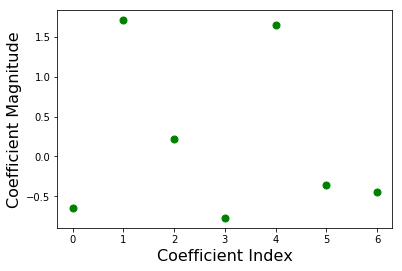

In [34]:
plot_coefficients(pipeline, 'CH3_Linear regression - no reg - no extra features')

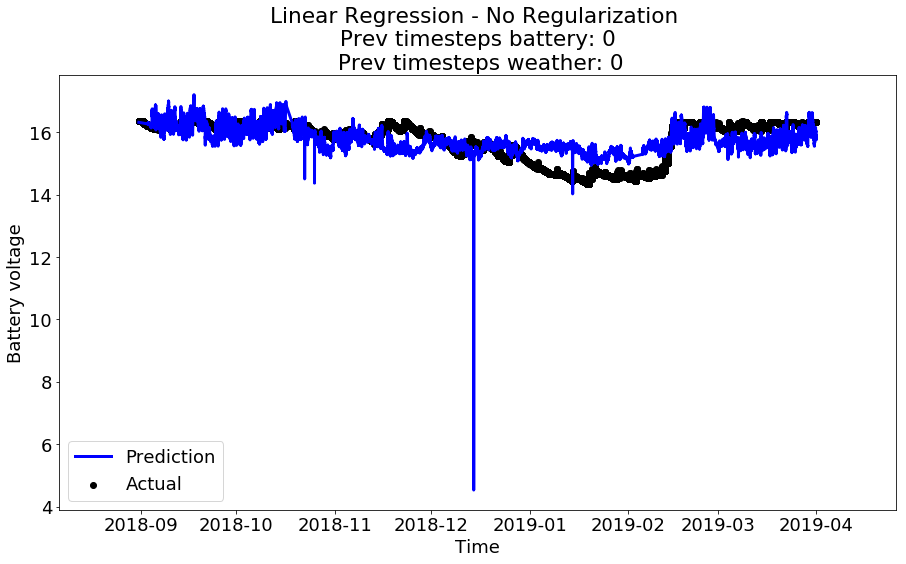

In [38]:
# Predict values based on trained set
y_pred = pipeline.predict(X)
plot_pred_actual(X, y, y_pred, prev_timesteps_bat, prev_timesteps_weather, 'msup1i70124')

## Linear regression without regularization - extra features
Since the previous analysis showed that we were underfitting the data and no good match was possible, we'll introduce new features. As a first attempt, we'll add data from previous timestamps as extra features. This can be data of the battery voltage but also the weather data. In the next part, we'll try to find some extra polynomials.

### Using extra battery voltages

Training score: 0.9998921528472432
Test score: 0.9998962308089696
Coefficients: 
          0         1         2         3         4         5         6  \
0  0.011185 -0.000825 -0.006656  0.001062 -0.002013 -0.001495 -0.000193   

          7  
0  2.029949  


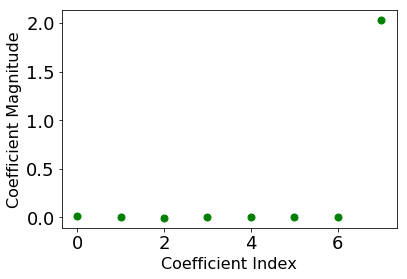

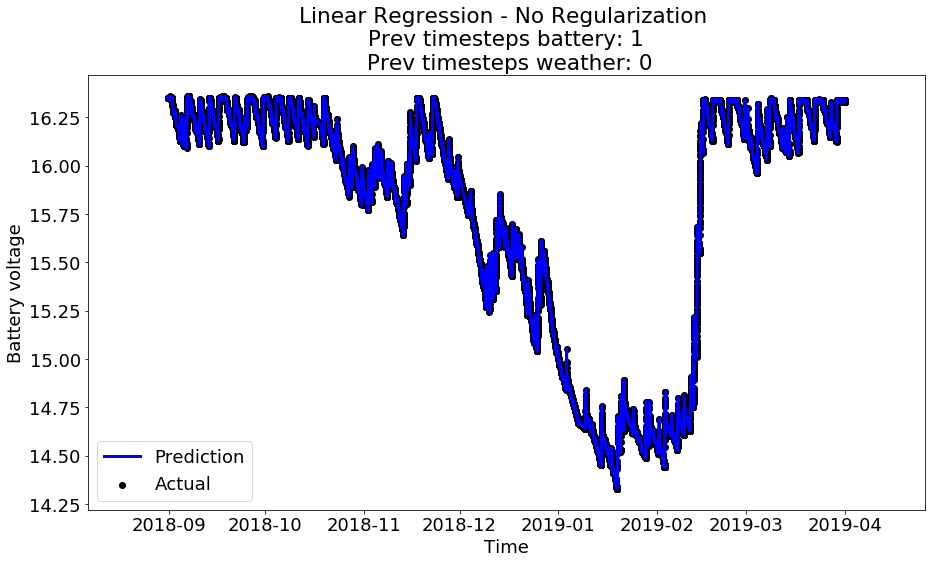

In [39]:
batt_id = 'munisense.msup1i70124'
battery_voltage = load_battery_voltage(batt_id)
a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 0
prev_timesteps_bat = 1

# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)

# Split data in train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Define pipeline
steps = [
    ('scalar', MinMaxScaler()),
    ('model', LinearRegression())
]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

plot_coefficients(pipeline, 'CH3_Linear regression - no reg - extra battery data - 1')

# Predict values based on trained set
y_pred = pipeline.predict(X)
plot_pred_actual(X, y, y_pred, prev_timesteps_bat, prev_timesteps_weather, 'msup1i70124')

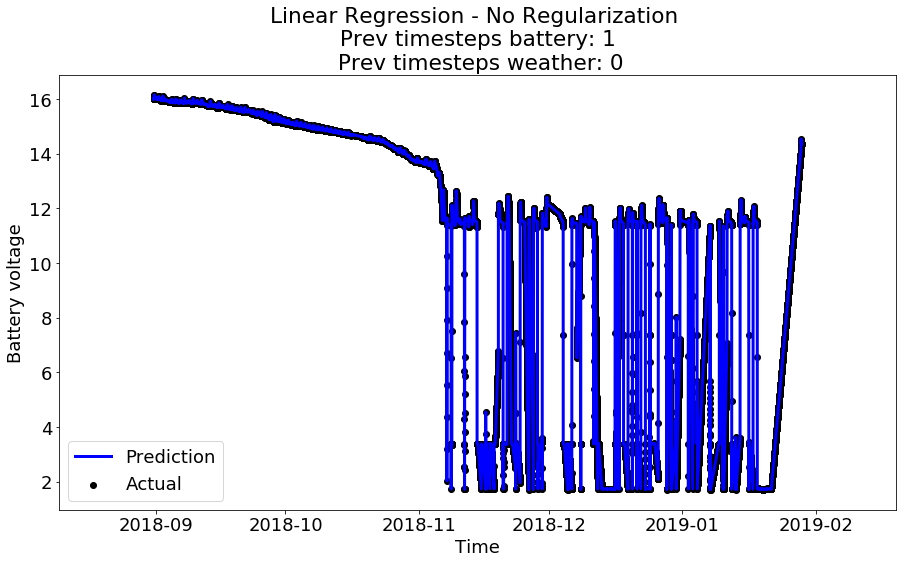

In [40]:
batt_id = 'munisense.msup1g30034'
battery_voltage = load_battery_voltage(batt_id)
b = battery_voltage.copy()
# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)
# Predict values based on trained set
y_pred = pipeline.predict(X)
plot_pred_actual(X, y, y_pred, prev_timesteps_bat, prev_timesteps_weather, 'msup1g30034')

Training score: 0.9998984569382922
Test score: 0.9998952992803725
Coefficients: 
         0         1         2         3         4         5        6   \
0  0.010577 -0.000807 -0.006727  0.001184 -0.002048 -0.001693 -0.00029   

         7         8         9         10        11        12        13  \
0  1.637289  0.370024 -0.012535  0.058733 -0.034486  0.057985  0.046407   

         14        15        16  
0 -0.048027 -0.002302 -0.043243  


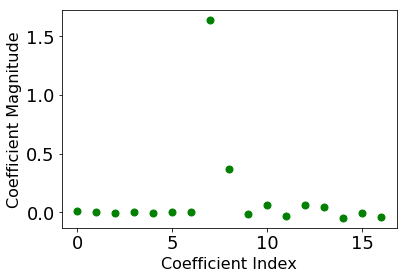

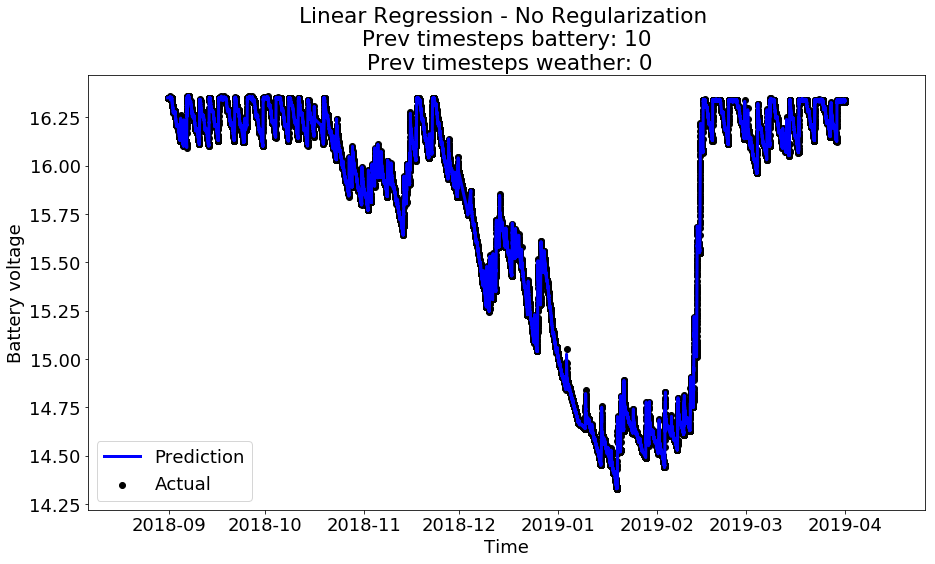

In [41]:
batt_id = 'munisense.msup1i70124'
battery_voltage = load_battery_voltage(batt_id)
a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 0
prev_timesteps_bat = 10

# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)

# Split data in train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Define pipeline
steps = [
    ('scalar', MinMaxScaler()),
    ('model', LinearRegression())
]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

plot_coefficients(pipeline, 'CH3_Linear regression - no reg - extra battery data - 10')

# Predict values based on trained set
y_pred = pipeline.predict(X)
plot_pred_actual(X, y, y_pred, prev_timesteps_bat, prev_timesteps_weather, 'msup1i70124')

Training score: 0.9999707599297435
Test score: 0.9999670085530028
Coefficients: 
         0         1         2        3         4         5         6   \
0  0.005131 -0.001193 -0.002527  0.00144  0.000501 -0.001296  0.000054   

         7         8         9         10        11        12        13  \
0  2.253711  0.307389  0.121838  0.187705  0.082265 -0.094292 -0.002896   

         14        15        16  
0  0.008385  0.017193 -0.120923  


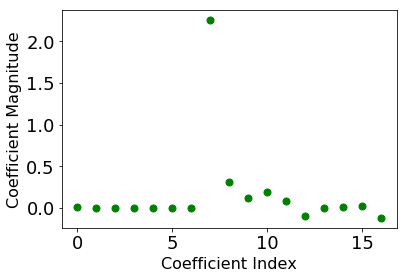

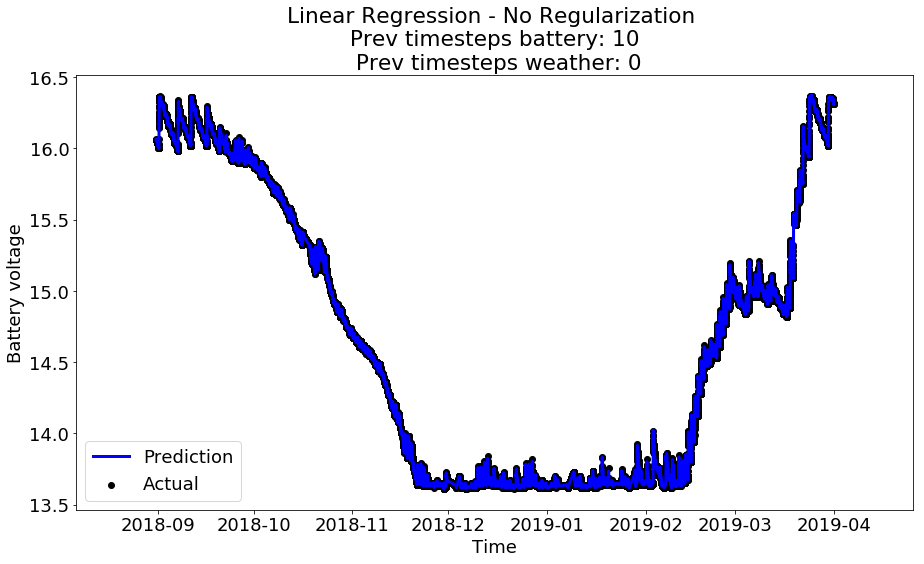

In [44]:
batt_id = 'munisense.msup1h90115'
battery_voltage = load_battery_voltage(batt_id)
a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 0
prev_timesteps_bat = 10

# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)

# Split data in train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Define pipeline
steps = [
    ('scalar', MinMaxScaler()),
    ('model', LinearRegression())
]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

plot_coefficients(pipeline, 'CH3_Linear regression - no reg - extra battery data - 10')

# Predict values based on trained set
y_pred = pipeline.predict(X)
plot_pred_actual(X, y, y_pred, prev_timesteps_bat, prev_timesteps_weather, 'msup1h90115')

### Using extra weather features

Training score: 0.4488622607288444
Test score: 0.35216302869143334
Coefficients: 
        0         1         2         3         4         5         6    \
0 -0.375037 -0.611466 -0.029749 -1.586265  0.034213  0.608839 -0.086914   

        7         8         9     ...         690       691       692  \
0  0.024289  0.787538 -0.163747   ...     0.04589  0.515217 -0.007663   

        693       694       695       696       697       698      699  
0  0.094676  6.782381  0.202439 -0.143214  0.477567  0.497649 -0.07968  

[1 rows x 700 columns]


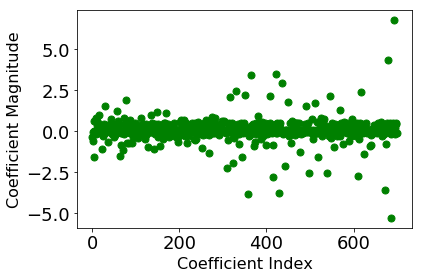

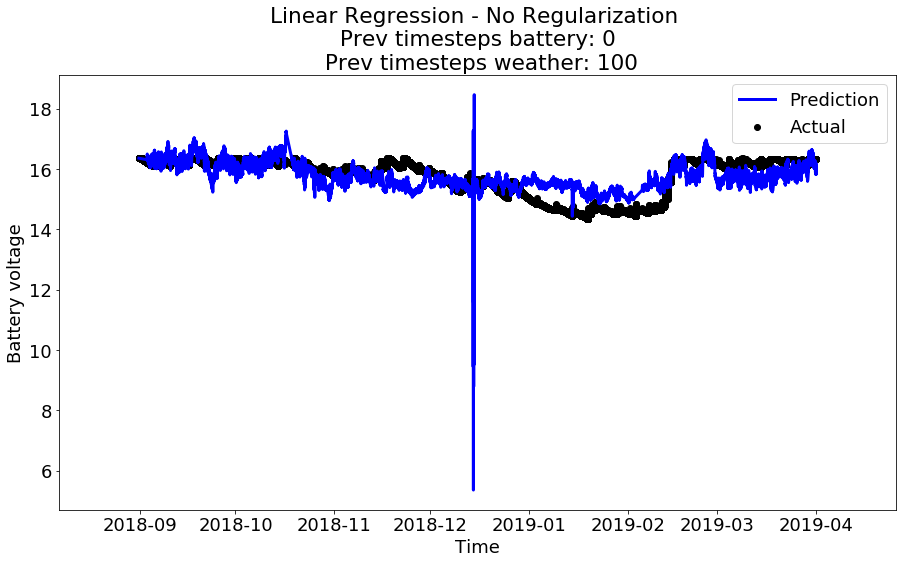

In [45]:
batt_id = 'munisense.msup1i70124'
battery_voltage = load_battery_voltage(batt_id)
a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 100
prev_timesteps_bat = 0

# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)

# Split data in train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Define pipeline
steps = [
    ('scalar', MinMaxScaler()),
    ('model', LinearRegression())
]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

plot_coefficients(pipeline, 'CH3_Linearregression-noreg-extraweatherdata-100')

# Predict values based on trained set
y_pred = pipeline.predict(X)
plot_pred_actual(X, y, y_pred, prev_timesteps_bat,prev_timesteps_weather, 'msup1i70124')

The results above show that we cannot only use weather variables to predict the battery voltages. The next thing we'll try is a combination of both previous battery values and weather variables.

### Combination of battery voltages and weather variables

Training score: 0.9998956599716562
Test score: 0.9998991758018952
Coefficients: 
         0         1         2         3         4         5         6   \
0  0.006322 -0.008683 -0.011202  0.011415  0.009022 -0.007617  0.000801   

        7         8         9     ...           30        31        32  \
0  0.00128 -0.005325 -0.001152    ...     0.021595 -0.009058 -0.008497   

         33        34        35        36        37        38        39  
0 -0.000458  0.000536  1.611566  0.390495 -0.017811  0.044892  0.000648  

[1 rows x 40 columns]


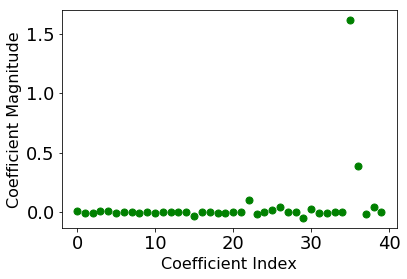

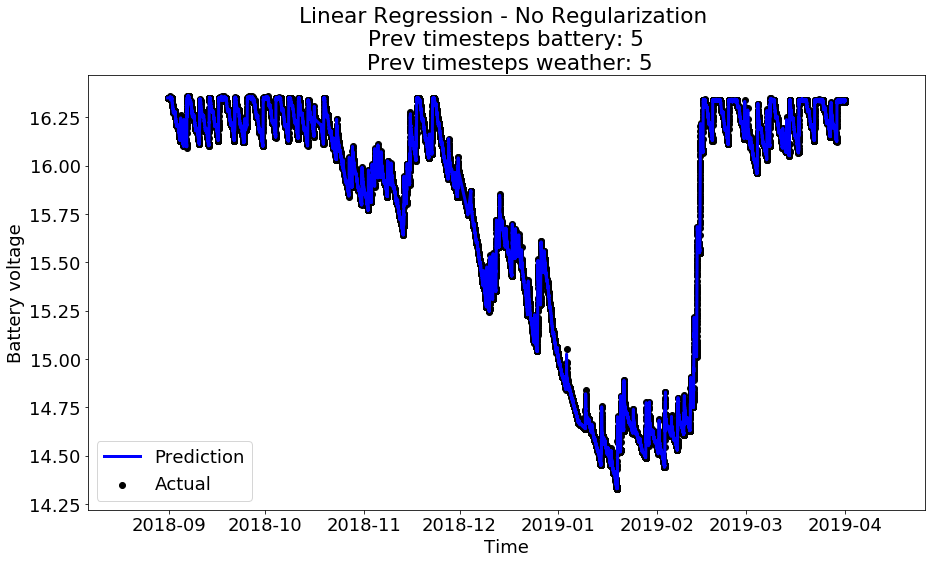

In [46]:
batt_id = 'munisense.msup1i70124'
battery_voltage = load_battery_voltage(batt_id)
a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 5
prev_timesteps_bat = 5

# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)

# Split data in train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Define pipeline
steps = [
    ('scalar', MinMaxScaler()),
    ('model', LinearRegression())
]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

plot_coefficients(pipeline, 'CH3_Linear regression - no reg - extra weather and battery data - 5')

# Predict values based on trained set
y_pred = pipeline.predict(X)
plot_pred_actual(X, y, y_pred, prev_timesteps_bat, prev_timesteps_weather, 'msup1i70124')

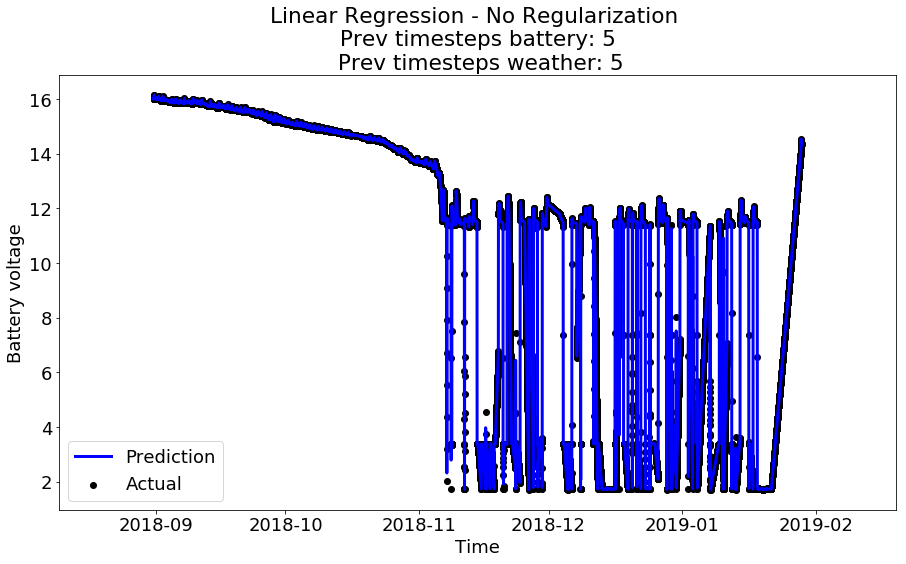

Test score: 0.9998991758018952


In [47]:
batt_id = 'munisense.msup1g30034'
battery_voltage = load_battery_voltage(batt_id)
b = battery_voltage.copy()
# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)
# Predict values based on trained set
y_pred = pipeline.predict(X)
plot_pred_actual(X, y, y_pred, prev_timesteps_bat, prev_timesteps_weather, 'msup1g30034')
print('Test score: {}'.format(pipeline.score(X_test.iloc[0:len(y_test)], y_test)))

The above results show that it is the battery voltage value of the previous timestamp which has the biggest influence on predicting the battery voltage whereas the coefficients of all the other features are a lot smaller. In the next part we'll try to use a model with regression to deal with this.

# Ridge Regression

## Import libraries

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.linear_model import RidgeCV
import numpy as np

## Run ridge regression
We run the algorithm with different values for parameter alpha. For each value of alpha, the coefficients are determined and finally the coefficients are plotted in function of alpha.

In [49]:
batt_id = 'munisense.msup1i70124'
battery_voltage = load_battery_voltage(batt_id)
a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 5
prev_timesteps_bat = 5

# Extend the weather data with more timestamps
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

n_alphas = 200
alphas = np.logspace(-5, 7, n_alphas)

coefs = []
for a in alphas:
    steps = [
        ('scalar', StandardScaler()),
        ('ridge', Ridge(alpha=a, fit_intercept=False))
    ]
    ridge_pipe = Pipeline(steps)
    ridge_pipe.fit(X_train, y_train)
    coefs.append(ridge_pipe.named_steps['ridge'].coef_[0])


In [50]:
X_scaled = preprocessing.scale(X_train)
clf = RidgeCV(alphas=alphas).fit(X_train, y_train)

In [51]:
clf.alpha_

0.007842822061337682

## Plot ridge coefficients in function of alpha

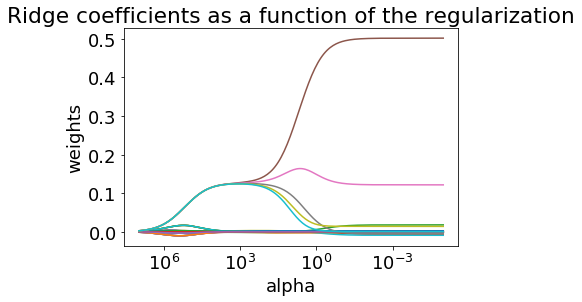

In [53]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.savefig(r'C:\Users\Jeff\Dropbox\ICT-Elektronica\Thesis\Text\fig\CH3_ridgecoefficients.png')
plt.show()

Conclusion: Regularization has no effect

## Try high value of alpha

In [54]:
batt_id = 'munisense.msup1i70124'
battery_voltage = load_battery_voltage(batt_id)
a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 5
prev_timesteps_bat = 5

# Extend the weather data with more timestamps
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
alpha = 50000
reg = linear_model.Ridge(alpha=alpha)
reg.fit(X_train, y_train)
reg.coef_
reg.intercept_
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))

0.8545460089087591
0.8537930721031363


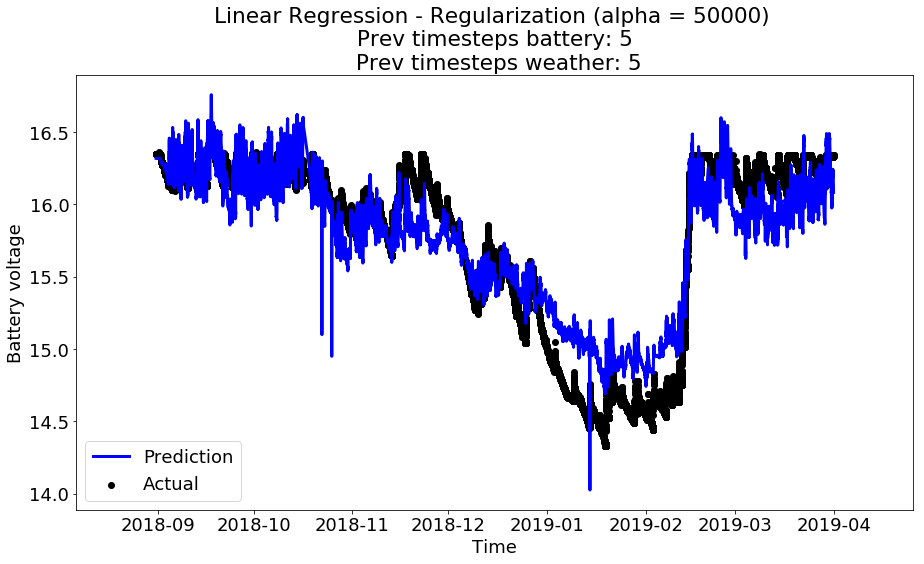

In [55]:
y_pred = reg.predict(X)
plot_pred_actual_reg(X, y, y_pred, prev_timesteps_bat, prev_timesteps_weather, 'msup1i70124', alpha)

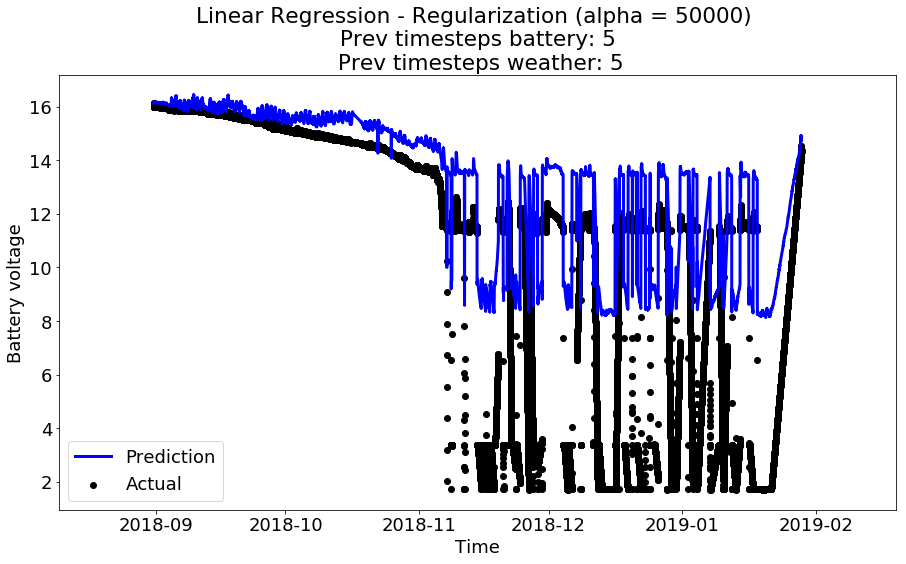

Test score: 0.9998991758018952


In [56]:
batt_id = 'munisense.msup1g30034'
battery_voltage = load_battery_voltage(batt_id)
a = weather_data.copy()
b = battery_voltage.copy()
# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)
# Predict values based on trained set
y_pred = reg.predict(X)
plot_pred_actual_reg(X, y, y_pred, prev_timesteps_bat, prev_timesteps_weather, 'msup1g30034', alpha)
print('Test score: {}'.format(pipeline.score(X_test.iloc[0:len(y_test)], y_test)))

# Polynomial Regression

## Import library

In [57]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [60]:
def plot_pred_actual_poly(X_test, y_test, y_pred, prev_timesteps, prev_timesteps_weather, batt_id, n_degree):
    # Plot prediction vs test set
    fig = plt.figure(figsize=(15,8))
    plt.scatter(y_test.index, y_test, label='Actual',  color='black')
    plt.plot(X_test.index, y_pred, label='Prediction', color='blue', linewidth=3)
    plt.xlabel('Time')
    plt.ylabel('Battery voltage')
    plt.legend()
    plt.title('Polynomial Regression (n = {}) - No Regularization \n Prev timesteps battery: {} \n Prev timesteps weather: {}'.format(n_degree,prev_timesteps_bat, prev_timesteps_weather))
    plt.savefig(r'C:\Users\Jeff\Dropbox\ICT-Elektronica\Thesis\scripts\Case 1 - Smart Lighting\Results\Polynomial Regression' + '/ts_{}_batt_{}_n_{}'.format(prev_timesteps, batt_id, n_degree))
    plt.show()

## Polynomial regression without regularization

Training score: 0.9999040084995661
Test score: 0.9990446879384596
Coefficients: 
            0         1         2         3         4         5         6    \
0  3.599463e-13 -0.002568 -0.003111 -0.003853  0.002796 -0.001898 -0.002636   

        7         8         9      ...          143       144       145  \
0  0.000124  0.003633  0.002917    ...    -0.000003  0.000299  0.264232   

        146       147       148       149       150       151       152  
0 -0.265417  0.000206  0.001787 -0.001852 -0.370199  0.763217 -0.393063  

[1 rows x 153 columns]


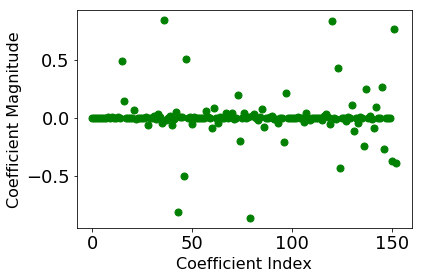

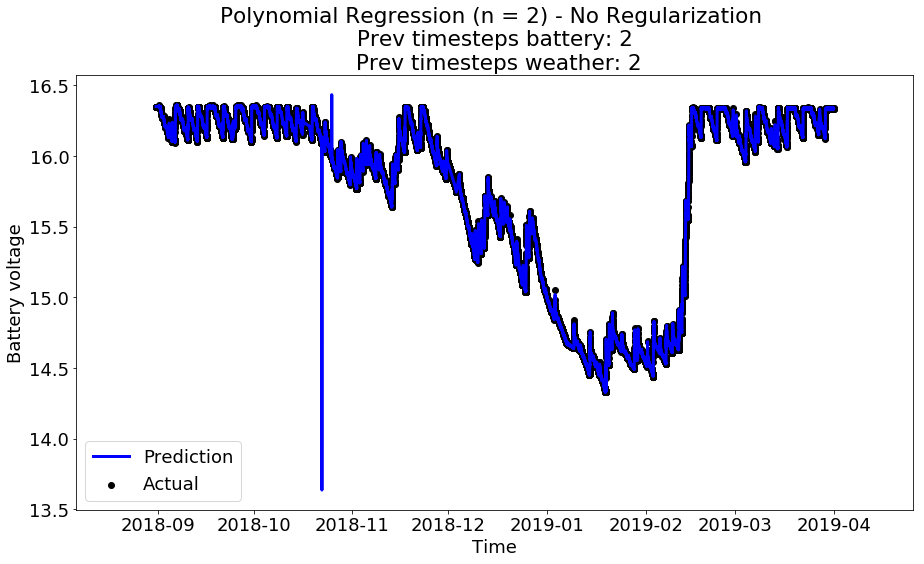

In [61]:
batt_id = 'munisense.msup1i70124'
battery_voltage = load_battery_voltage(batt_id)
a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 2
prev_timesteps_bat = 2
n_degree = 2

# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Define pipeline
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=n_degree)),
    ('model', LinearRegression())
]

pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

plot_coefficients(pipeline,'CH3_Polynomialregression-noreg-extrdata-2')

# Predict values based on trained set
y_pred = pipeline.predict(X)
plot_pred_actual_poly(X, y, y_pred, prev_timesteps_bat, prev_timesteps_weather, 'msup1i70124', n_degree)

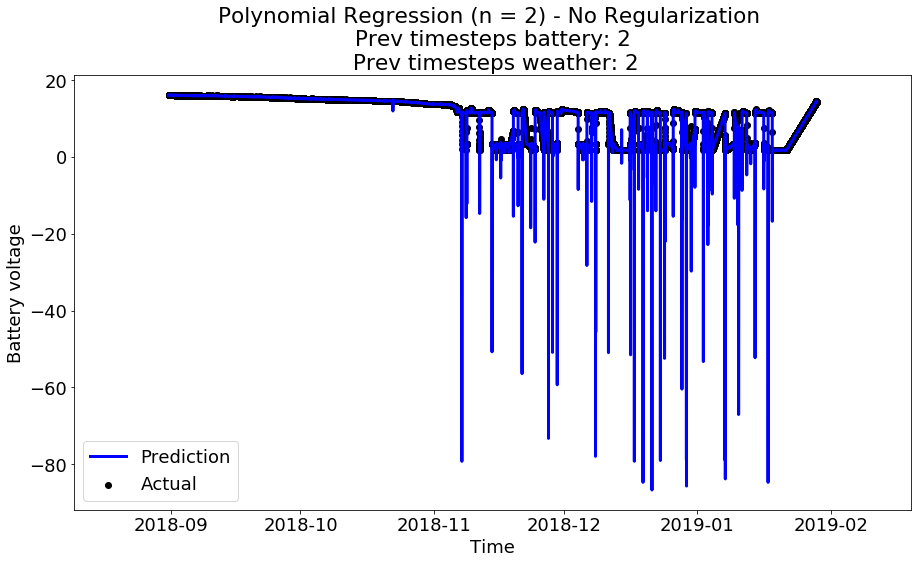

Test score: 0.9990446879384596


In [62]:
batt_id = 'munisense.msup1g30034'
battery_voltage = load_battery_voltage(batt_id)
a = weather_data.copy()
b = battery_voltage.copy()
# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)
# Predict values based on trained set
y_pred = pipeline.predict(X)
plot_pred_actual_poly(X, y, y_pred, prev_timesteps_bat, prev_timesteps_weather, 'msup1g30034', n_degree)
print('Test score: {}'.format(pipeline.score(X_test.iloc[0:len(y_test)], y_test)))

## Polynomial regression with regularization

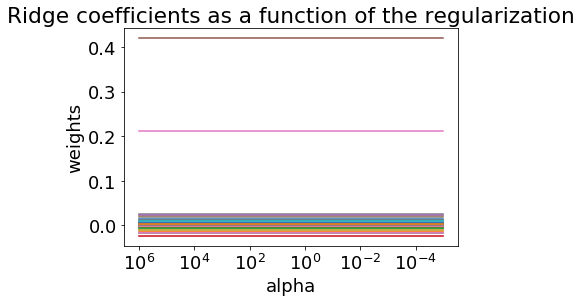

In [64]:
batt_id = 'munisense.msup1i70124'
battery_voltage = load_battery_voltage(batt_id)
a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 2
prev_timesteps_bat = 2
n_degree = 2

# Preprocess data
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)



n_alphas = 200
alphas = np.logspace(-5, 6, n_alphas)

coefs = []
for a in alphas:
    # Define pipeline
    steps = [
        ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(degree=n_degree)),
        ('model', Ridge())
    ]
    ridge_pipe = Pipeline(steps)
    ridge_pipe.fit(X_train, y_train)
    coefs.append(ridge_pipe.named_steps['model'].coef_[0])

# Plot results
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.savefig(r'C:\Users\Jeff\Dropbox\ICT-Elektronica\Thesis\Text\fig\CH3_poly_ridge_coeff.png')
plt.show()

In [65]:
batt_id = 'munisense.msup1i70124'
battery_voltage = load_battery_voltage(batt_id)
a = weather_data.copy()
b = battery_voltage.copy()

# Choose settings
prev_timesteps_weather = 2
prev_timesteps_bat = 2

# Extend the weather data with more timestamps
X, y = add_features(a, b, prev_timesteps_bat, prev_timesteps_weather)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('ridge', Ridge())
]
ridge_pipe = Pipeline(steps)

param_grid = {'poly__degree': [1, 2, 3],
             'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(ridge_pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# print('Training Score: {}'.format(ridge_pipe.score(X_train, y_train)))
# print('Test Score: {}'.format(ridge_pipe.score(X_test, y_test)))

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'poly__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

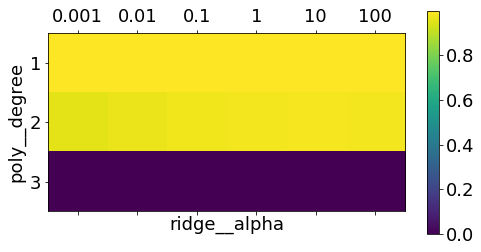

In [66]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3,-1),
           vmin=0,cmap='viridis')
plt.xlabel("ridge__alpha")
plt.ylabel("poly__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])),param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['poly__degree'])), param_grid['poly__degree'])
plt.colorbar()

In [67]:
print("Best parameters: {}".format(grid.best_params_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best parameters: {'poly__degree': 1, 'ridge__alpha': 0.01}
Test-set score: 1.00
